# Lab 1 - Introduction to Control

The main objective in this lab is to learn about feedback and the advantages of feedback (improved performance, disturbance rejection). In this lab we will investigate the 2 disk rotational system. We will implement two control strategies: 2-state control and proportional control. The objective of the controller will be to control the position of the second disk. 

# 2 Disk System

Recall the following derivation of the 2-Disk system

![2 Disk Graphic Diagram](2diskGraphic.png "2 Disk Graphic Diagram")

A torque is applied by a motor to a system with two disks. The disks are connected by a thin flexible rod. The rod is supported by bearings on both sides of the disks. The torque applied by the motor is known. The angular position of the right disk is measured. 

# Schematic Diagram
![2 Disk Schematic Diagram](2diskSchematic.png "2 Disk Schematic Diagram")

We are interested in the relationship between the torque applied by the motor, $T_M$, and the angular position of the second disk, $\theta_2$. During the lectures, we derived the following differential equation for the 2-disk system (see Notebook on State Space):
$$
\begin{align*}
\frac{J_1J_2}{k}\frac{\text{d}^4\theta_2}{\text{dt}^4} + \frac{J_1b + J_2b}{k}\frac{\text{d}^3\theta_2}{\text{dt}^3} + (J_1 + J_2 + \frac{b^2}{k}) \frac{\text{d}^2\theta_2}{\text{dt}^2} + 2b\frac{\text{d}\theta_2}{\text{dt}}  &= T_M(t) 
\end{align*}
$$

Take Laplace transform of both sides:

$$
\begin{align*}
\frac{\Theta_2(s)}{T_M(s)} = \frac{1}{ \frac{J_1J_2}{k}s^4 + \frac{J_1b + J_2b}{k}s^3 + (J_1 + J_2 + \frac{b^2}{k}) s^2 + 2bs}  
\end{align*}
$$

# Incorporating the motor into the model

When we are designing the controller, we can manipulate the voltage applied to the motor. In other words, the controller is just an algorithm that is adjusting the voltage on the motor in order to position the second disk at the desired angle. 

To test our design in simulation, we first need a simulation model. We need to be able to simulate the response of the second disk to a voltage applied to the motor. In other words, we need a transfer function where voltage is the input, and angular position of the second disk is the output. Assume that the transfer function from the voltage applied to the motor to position of the motor is:
$$
    \begin{align*}
        \frac{T_M(s)}{V_m(s)} = \frac{k_m}{s+a}
    \end{align*}
$$

# Question 1

Write a transfer function model for the complete system. In other words, determine the transfer function where voltage is the input, and angular position of the second disk is the output. 

Note: you don't need to multiply out any factors in the denominator. Just leave the denominator in factored form.

In [2]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Question 2

Generate the step response of the system by completing the code below.

Note: Use the ct.tf function to create transfer functions. The control systems package will multiply transfer functions correctly. For example run the following code:

In [6]:
TF1 = ct.tf([1], [1, 2])
TF2 = ct.tf([1], [1, 3])
TF3 = TF1*TF2

print('TF1=', TF1)
print('TF2=', TF2)
print('TF1*TF2=', TF3)

TF1= 
  1
-----
s + 2

TF2= 
  1
-----
s + 3

TF1*TF2= 
      1
-------------
s^2 + 5 s + 6



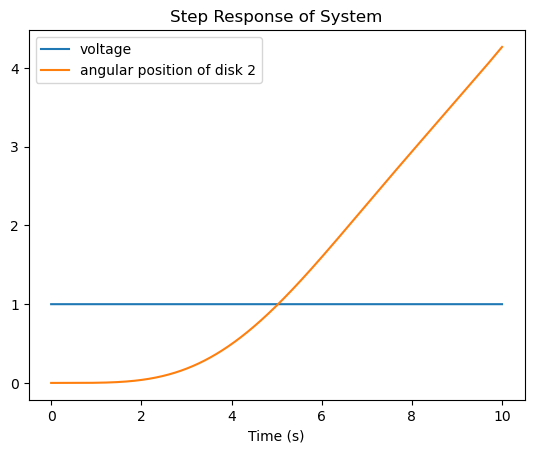

In [11]:
# set system parameters
J1 = 2
J2 = 5
k = 1
b = 0.5
km = 5
a = 5

d1= (J1*J2)/(k)
d2= ((J1*b)+(J2*b))/(k)
d3= J1 + J2 + ((pow(b,2))/k)
d4 = 2*b
TF1 = ct.tf([1],[d1,d2,d3,d4,0])
TF2 = ct.tf([km], [1, a])

#Enter your code here for the transfer function of the system:
G_sys = TF1*TF2


# generate step response
t = np.linspace(0,10,10000)
data_step = ct.step_response(G_sys,T=t)

fig, ax = plt.subplots(1,1)
ax.plot(np.squeeze(data_step.t),np.squeeze(data_step.u), label='voltage')
ax.plot(np.squeeze(data_step.t), np.squeeze(data_step.y), label='angular position of disk 2')
ax.set_title('Step Response of System')
ax.set_xlabel('Time (s)')
plt.legend()
plt.show()

# Question 3

Look at the Bode plot below. What features do you see?

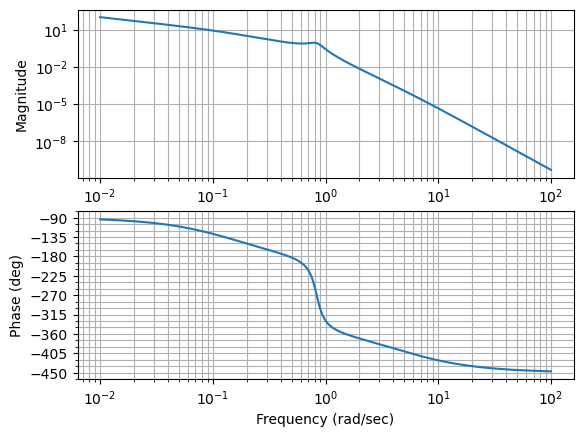

In [12]:
mag, phase, omega = ct.bode(G_sys)

# Question 4

Come see the physical set-up and see what a resonance peak looks like in practice.

# 2 State Controller

In this section we will explore the effect of feedback on a system.

# Feedback

Suppose that we wish to move the second disk to a desired position. 

We will implement the following strategy: 
- if the current position of the disk is less than the desired position, then apply a positive voltage. 
- if the current position of the disk is greater than the desired position, then apply a negative voltage. 

This is called a 2-state controller. 

# Question 5

Draw a block diagram of the 2 disk system and the controller. Include the following signals in your diagram:
- desired position
- measured position
- voltage applied to motor

Include the following transfer functions (blocks) in your diagram:
- controller
- motor
- 2-disks

Hint: 
- The Controller is a block with 2 inputs, 1 output


# Question 6

Complete the following code to implement the 2-state controller. Choose a value for which voltage should be applied to the motor. 

In [19]:
def controller_out(t,x,u,params={}):
    desired_position = u[1]
    measured_position = u[0]

    voltage_to_apply =  5
    ### Your code here:
    if measured_position < desired_position:
        voltage_out = voltage_to_apply
    elif measured_position > desired_position:
        voltage_out = -voltage_to_apply
    else:
        voltage_out = 0


    return voltage_out

# Simulation

The following code sets up a simulator for the 2 disk system with the controller that you defined above. Run the code.

In [14]:
def controller_update(t, x, u, params={}): 
    return 1 

# def controller_out(t,x,u,params={}):
#     return 0.1*(u[1]-u[0])

def simulate_closed_loop_2disk(G_disks,t,r,x0):
    controller = ct.NonlinearIOSystem(
        controller_update, controller_out, name='controller',
        inputs=('cur_position','desired_position'), outputs=('voltage'), states=('x'))
    disks = ct.tf2io(G_disks,name='disks', inputs='voltage', outputs='position')

    closed_loop_system = ct.InterconnectedSystem(
        (controller, disks), name='Two_Disks',
        connections=(
            ['disks.voltage', 'controller.voltage'],
            ['controller.cur_position', 'disks.position']),
        inplist=('controller.desired_position'),
        inputs=('ref'),
        outlist=('disks.position','disks.voltage'),
        outputs=('theta2', 'vin'))

    t, y_nonlin = ct.input_output_response(
            closed_loop_system, t, r, x0)
    return t,y_nonlin

# Plot the Results of the Simulation

Use the code below to plot the results of the simulation. Try different values of 'voltage_to_apply'. What do you notice? Is there a trend? Does it fail at some point? Why or why not?

(2, 10000)


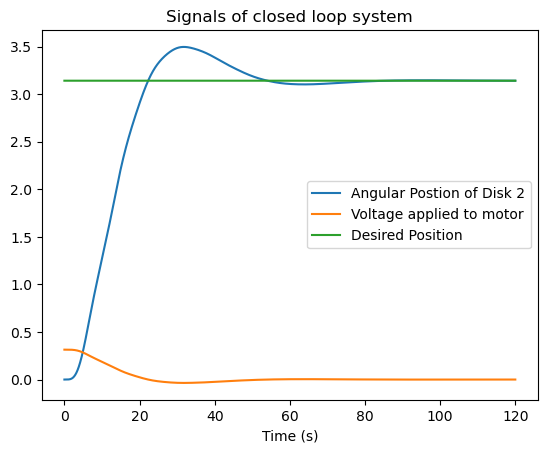

In [22]:
x0 = np.array([0])
t = np.linspace(0,120,10000)
r = 180*np.pi/180 * np.ones(t.shape)

t,y = simulate_closed_loop_2disk(G_sys,t,r,x0)

print(y.shape)

fig, ax = plt.subplots(1)
ax.plot(t,y[0,:],label='Angular Postion of Disk 2')
ax.plot(t,y[1,:],label='Voltage applied to motor')
ax.plot(t,r,label='Desired Position')
ax.set_title('Signals of closed loop system')
ax.set_xlabel('Time (s)')
ax.legend()


# Proportional Control Strategy

The main weakness of the above strategy is that when we are close to the disired position, we still are applying large voltages. It would be better if the closer we are to the desired position, the smaller the voltage we apply to the motor. This is called a proportional controller.

In [21]:
def controller_out(t,x,u,params={}):
    desired_position = u[1]
    measured_position = u[0]
    
    K =  0.1  # choose K>0
    voltage_out = K*(desired_position-measured_position)
    
    return voltage_out

# Question 7

Understand the code above. How does this line of code implement the desired behavior?

Draw another block diagram with the proportional controller. This time, draw the controller using a summation block and a transfer function block. 

# Simulation

Run the simulator again, but with the new controller and plot the results. Vary the proportional constant $K$. How does the value of $K$ affect the response of the overall system? Is there a trend? Does it fail at some point? Why or why not does it fail? 

# Physical System

Try the proportional controller on the physical system. See the response of the controller due to disturbances. 